# Exercise 08 - Size optimization for continua


## Task 1 - Book shelf

Let us consider a bookshelf that needs a support structure. The design domain is given by a unit square $x \in [0, 1]^2$ and a maximum thickness $d_{max}=0.1$. The left boundary of the domain $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

<div>
    <center>
        <img src="../figures/domain.png" width="250"/>
    </center>
</div>


In [1]:
from math import sqrt

import torch
from simple_fem import FEM

torch.set_default_dtype(torch.double)

a) Reuse the code from last exercise´s code to reproduce the example domain. Use a constant thickness of $d=0.05$ for the entire domain, forces $f(\mathbf{x}) = 1.0/N, \mathbf{x} \in \partial \Omega_N$ and the material parameters $E=1000.0, \nu=0.25$.

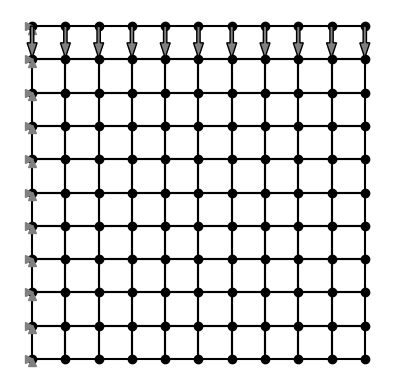

In [2]:
# Create nodes
N = 10
n1 = torch.linspace(0.0, 1, N + 1)
n2 = torch.linspace(0.0, 1, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[N * (N + 1) : (N + 1) * (N + 1), 1] = -1.0 / N
forces[(N + 1) * (N + 1) - 1, 1] = 0.5 * forces[(N + 1) * (N + 1) - 1, 1]

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
for i in range(N + 1):
    constraints[i * (N + 1), :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Material
E = 1000.0
nu = 0.25

# Create and plot the domain
square = FEM(nodes, elements, forces, constraints, thickness=thickness, E=E, nu=nu)
square.plot()

b) To save material, the bookshelf should use only 50% of that given design space, while being as stiff as possible to support many books. We want to achieve this by a variable thickness distribution of the component. 

You are provided with a function that performs root finding with the bisection method from a previous exercise. Now, you should implement a size optimization algorithm with MMA in a function named `optimize(fem, d_0, d_min, d_max, V_0, iter=15)` that takes the FEM model `fem`, the initial thickness distribution `d_0`, the minimum and maximum thickness distributions `d_min, d_max`, the volume constraint, and the maximum iteration count `iter` with a default value of 15.

In [3]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [4]:
def optimize(fem, d_0, d_min, d_max, V_0, iter=15):
    # List for thickness results and lower asymptotes
    d = [d_0]
    L = []
    # Element-wise areas
    areas = fem.areas()
    # MMA parameter
    s = 0.7

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, areas) > V_0:
        raise Exception("d_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at d_k
        fem.thickness = d[k]
        u_k, f_k = fem.solve()

        # Compute strain energy density
        w_k = fem.element_strain_energies(u_k)

        # Compute lower asymptote
        if k <= 1:
            L_k = d[k] - s * (d_max - d_min)
        else:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (d[k][j] - d[k - 1][j]) * (d[k - 1][j] - d[k - 2][j]) < 0.0:
                    L_k[j] = d[k][j] - s * (d[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = d[k][j] - 1 / sqrt(s) * (d[k - 1][j] - L[k - 1][j])
        L.append(L_k)

        # Compute lower move limit in this step
        d_min_k = torch.max(d_min, 0.9 * L[k] + 0.1 * d[k])

        # Analytical solution
        def d_star(mu):
            d_hat = L[k] + torch.sqrt((2.0 * w_k * (L[k] - d[k]) ** 2) / (mu * areas))
            return torch.clamp(d_hat, d_min_k, d_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(d_star(mu), areas) - V_0

        # Solve dual problem
        mu_star = bisection(grad, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k:3d} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        d.append(d_star(mu_star))

    return d

c) Now run the optimization with $d_0=0.05, d_{min}=0.001, d_{max}=0.1$ and a volume constraint $V_0=50\%$ of the maximum design volume.

Iteration k=  0 - Compliance: 0.03683
Iteration k=  1 - Compliance: 0.02847
Iteration k=  2 - Compliance: 0.02852
Iteration k=  3 - Compliance: 0.02902
Iteration k=  4 - Compliance: 0.02845
Iteration k=  5 - Compliance: 0.02829
Iteration k=  6 - Compliance: 0.02827
Iteration k=  7 - Compliance: 0.02807
Iteration k=  8 - Compliance: 0.02813
Iteration k=  9 - Compliance: 0.02790
Iteration k= 10 - Compliance: 0.02785
Iteration k= 11 - Compliance: 0.02788
Iteration k= 12 - Compliance: 0.02783
Iteration k= 13 - Compliance: 0.02785
Iteration k= 14 - Compliance: 0.02781
Iteration k= 15 - Compliance: 0.02781
Iteration k= 16 - Compliance: 0.02781
Iteration k= 17 - Compliance: 0.02780
Iteration k= 18 - Compliance: 0.02780
Iteration k= 19 - Compliance: 0.02781
Iteration k= 20 - Compliance: 0.02781
Iteration k= 21 - Compliance: 0.02780
Iteration k= 22 - Compliance: 0.02780
Iteration k= 23 - Compliance: 0.02780
Iteration k= 24 - Compliance: 0.02780
Iteration k= 25 - Compliance: 0.02780
Iteration k=

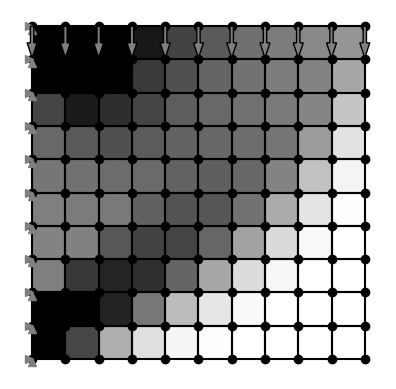

In [5]:
# Initial thickness, minimum thickness, maximum thickness
d_0 = 0.05 * torch.ones(len(square.elements))
d_min = 0.001 * torch.ones_like(d_0)
d_max = 0.1 * torch.ones_like(d_0)

# Initial volume (50% of maximum design volume)
areas = square.areas()
V0 = 0.5 * torch.inner(d_max, areas)

# Optimize and visualize results
d_opt = optimize(square, d_0, d_min, d_max, V0, iter=30)
square.plot(element_property=d_opt[-1])

d) Plot the evolution of design variables vs. iterations. What does the graph tell you?

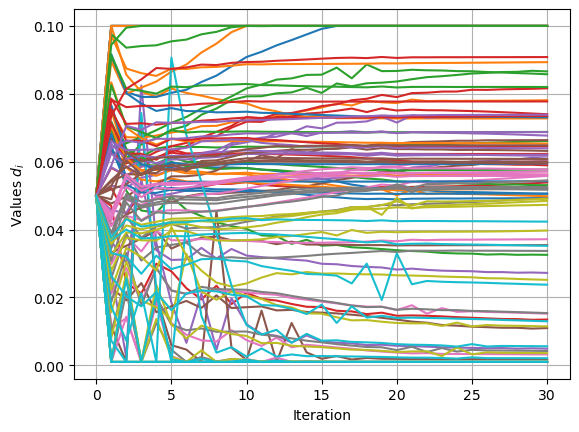

In [6]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

e) How do you interpret the design? Decide which manufacturing process you would like to use and use a CAD software to create a design based on your optimization. You may use the following code to get patches for different thickness sheets. You can build the optimal solution at home with cardboad by stacking the patches and gluing them together.

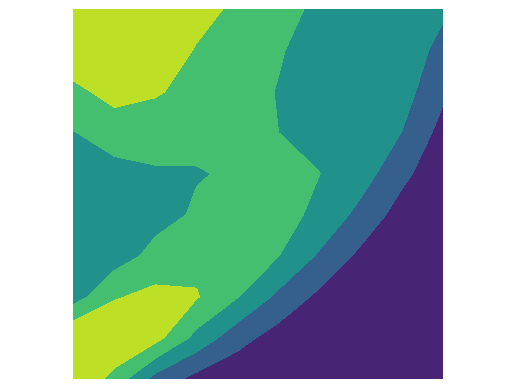

In [7]:
centers = square.nodes[square.elements].mean(dim=1)
plt.contourf(
    centers[:, 0].reshape(N, N),
    centers[:, 1].reshape(N, N),
    d_opt[-1].reshape(N, N),
    levels=4,
)
plt.axis("equal")
plt.axis("off")
plt.show()